In [251]:
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
import plotly.graph_objects as go
import scipy.io as scio
import random
from matplotlib import pyplot as plt

Governing Equations:

$m\ddot{x} + kx + d\dot{x} = 0$

or in state-space form:

$\dot{\mathbf{x}} = \begin{bmatrix}
0 & 1\\
-\frac{k}{m} & -\frac{d}{m}
\end{bmatrix}\mathbf{x}
$

where we set $m = 1$; $\mathbf{x} = \begin{bmatrix}x\\v\end{bmatrix}$.

In [252]:
#

k = 2        # stiffness
d = .1        # damping

# spring-mass-damper system
A = np.array([[0, 1], [-k, -d]])  # \dot{x} = Ax

In [253]:

dt = 0.01 # time step
T = 10     # amount of time to integrate
n = int(T/dt)
ts = np.linspace(0, T, n)
x0 = [2, 0]  # initial condition (x=2, v=0)
print(n)

1000


In [254]:
# compute better integral using built-in python code
# 4th-order Runge Kutta
from scipy.integrate import solve_ivp

def linear_ode(t, x):
    return A @ x

linear_ode_solution = solve_ivp(linear_ode, (0, T), x0, t_eval=ts)
xGood = linear_ode_solution.y

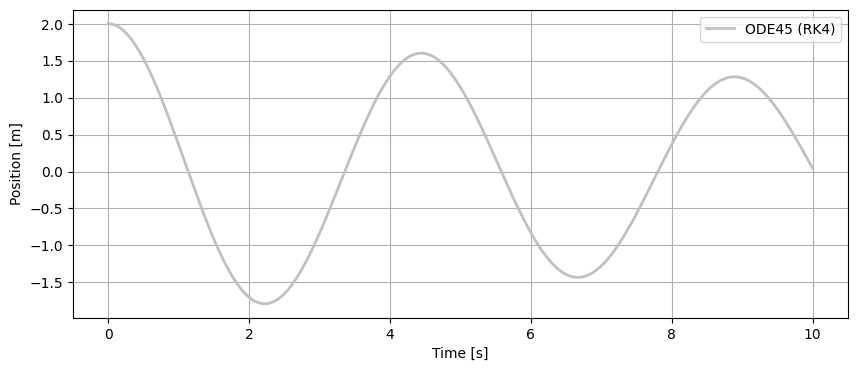

In [255]:
# Time series
plt.figure(figsize=(10, 4))
plt.plot(ts, xGood[0, :],color = "silver", lw = 2)

plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.legend(['ODE45 (RK4)'])
plt.grid(True)


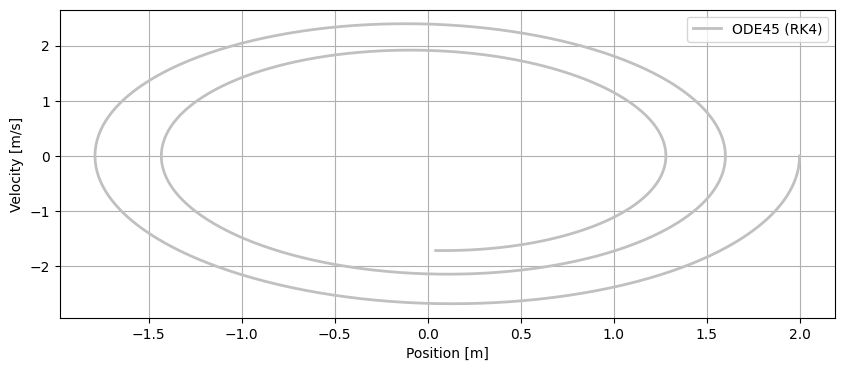

In [256]:
# Phase Plot
plt.figure(figsize=(10, 4))
plt.plot(xGood[0, :], xGood[1, :], color = "silver", lw = 2)
plt.xlabel('Position [m]')
plt.ylabel('Velocity [m/s]')
plt.legend(['ODE45 (RK4)'])
plt.grid(True)

In [257]:
n_train = int(0.8*n)
# n_train = 1
u_train = xGood[0,:n_train]
t_train = ts[:n_train]

print(u_train.shape)
print(t_train.shape)

(800,)
(800,)


In [258]:
# # Sampling domain data
# domain_x = scio.loadmat(dataFile)['domain_x']
# domain_t = scio.loadmat(dataFile)['domain_t']
# domain_h = scio.loadmat(dataFile)['domain_u']

In [259]:
# data preparation
n_f = 10000
f_batch_size = 32

reg_in = torch.from_numpy(t_train).type(torch.float32)  # input x and t
reg_in = reg_in[:,None]
reg_label = torch.from_numpy(u_train).type(torch.float32) # output h
reg_label = reg_label[:,None]
print(reg_in.shape)
print(reg_label.shape)

f_x = np.random.uniform(0, 1, n_f)
f_t = np.random.uniform(0, 10, n_f)
f_data = np.vstack([f_x, f_t]).T

f_x = Variable(torch.from_numpy(f_data[:, 0:1]).type(torch.FloatTensor), requires_grad=True)
f_t = Variable(torch.from_numpy(f_data[:, 1:2]).type(torch.FloatTensor), requires_grad=True)

f_dataset = torch.utils.data.TensorDataset(f_x, f_t)
f_data_loader = torch.utils.data.DataLoader(f_dataset, batch_size = f_batch_size, shuffle=True)

# f_t = np.random.uniform(0, 7, n_f)
# f_data = np.vstack([f_x, f_t]).T

# f_x = Variable(torch.from_numpy(f_data[:, 0:1]).type(torch.FloatTensor), requires_grad=True)
# f_t = Variable(torch.from_numpy(f_data[:, 1:2]).type(torch.FloatTensor), requires_grad=True)

# f_dataset = torch.utils.data.TensorDataset(f_x, f_t)
# f_data_loader = torch.utils.data.DataLoader(f_dataset, batch_size=f_batch_size, shuffle=True)

torch.Size([800, 1])
torch.Size([800, 1])


In [260]:
# Define a MLP and function f
class MLP(nn.Module):
    def __init__(self, in_dim = 1,  hidden_dim = 128, out_dim = 1):

        super(MLP, self).__init__()
        self.mlp = nn.Sequential(
                                nn.Linear(in_dim, hidden_dim),
                                nn.Tanh(),
                                nn.Linear(hidden_dim, hidden_dim),
                                nn.Tanh(),
                                nn.Linear(hidden_dim, hidden_dim),
                                nn.Tanh(),
                                nn.Linear(hidden_dim, out_dim),
                                        )

    def forward(self, data_in):
        return self.mlp(data_in)

model = MLP()

class f_t(nn.Module):

    def __init__(self):

        super(f_t, self).__init__()
        self.k = nn.Parameter(1*torch.ones(1, ), requires_grad=True)
        self.c = nn.Parameter(1*torch.ones(1, ), requires_grad=True)

    def forward(self,  t):
        u = model(t)
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u),
                                  create_graph=True, retain_graph=True)[0]
        u_tt = torch.autograd.grad(u_t, t, grad_outputs=torch.ones_like(u),
                                  create_graph=True, retain_graph=True)[0]
        return u_tt  + self.k*u + self.c* u_t



In [261]:
# Training the PINN
n_epoch = 50
f_model = f_t()
paras = list(model.parameters()) + list(f_model.parameters())
optimizer = optim.Adam(paras, lr=1e-3)
Alpha = np.zeros(n_epoch,)
Alpha_c = np.zeros(n_epoch,)

for epoch in range(n_epoch):
    for x, t in tqdm(f_data_loader):

        optimizer.zero_grad()
        pred = model(reg_in)
        reg_loss = torch.mean((reg_label - pred) ** 2)
        f_loss = torch.mean(f_model(t) ** 2)

        loss =  reg_loss +f_loss   # adjust the coefficients between two losses
        loss.backward(retain_graph=True)
        optimizer.step()

    print("epoch = {}, loss = {}".format(epoch, loss))
    print("epoch = {}, f_loss = {}".format(epoch, f_loss))
    print("epoch = {}, reg_loss = {}".format(epoch, reg_loss))
    print(f_model.k.detach().numpy())
    print(f_model.c.detach().numpy())
    Alpha[epoch] = f_model.k.detach().numpy()
    Alpha_c[epoch] = f_model.c.detach().numpy()

100%|██████████| 313/313 [00:04<00:00, 66.48it/s]
<ipython-input-261-19aeeca0c172>:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Alpha[epoch] = f_model.k.detach().numpy()
<ipython-input-261-19aeeca0c172>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Alpha_c[epoch] = f_model.c.detach().numpy()


epoch = 0, loss = 0.6714585423469543
epoch = 0, f_loss = 0.09082712233066559
epoch = 0, reg_loss = 0.58063143491745
[1.1635765]
[0.8288502]


100%|██████████| 313/313 [00:03<00:00, 83.41it/s]


epoch = 1, loss = 0.29218393564224243
epoch = 1, f_loss = 0.055915120989084244
epoch = 1, reg_loss = 0.2362688034772873
[1.4413408]
[0.52839786]


100%|██████████| 313/313 [00:03<00:00, 81.62it/s]


epoch = 2, loss = 0.20795822143554688
epoch = 2, f_loss = 0.1045505553483963
epoch = 2, reg_loss = 0.10340765863656998
[1.6333554]
[0.3342946]


100%|██████████| 313/313 [00:04<00:00, 67.46it/s]


epoch = 3, loss = 0.16040906310081482
epoch = 3, f_loss = 0.084523506462574
epoch = 3, reg_loss = 0.07588556408882141
[1.7082292]
[0.3010643]


100%|██████████| 313/313 [00:03<00:00, 82.39it/s]


epoch = 4, loss = 0.17156773805618286
epoch = 4, f_loss = 0.10860329866409302
epoch = 4, reg_loss = 0.06296443194150925
[1.7433879]
[0.29853967]


100%|██████████| 313/313 [00:03<00:00, 79.40it/s]


epoch = 5, loss = 0.13177476823329926
epoch = 5, f_loss = 0.06762538105249405
epoch = 5, reg_loss = 0.0641493871808052
[1.7868222]
[0.2924239]


100%|██████████| 313/313 [00:04<00:00, 66.66it/s]


epoch = 6, loss = 0.19508177042007446
epoch = 6, f_loss = 0.129492849111557
epoch = 6, reg_loss = 0.06558892875909805
[1.8000675]
[0.2898493]


100%|██████████| 313/313 [00:03<00:00, 82.62it/s]


epoch = 7, loss = 0.07336699962615967
epoch = 7, f_loss = 0.04226221889257431
epoch = 7, reg_loss = 0.031104784458875656
[1.8527516]
[0.25866225]


100%|██████████| 313/313 [00:03<00:00, 81.39it/s]


epoch = 8, loss = 0.012739207595586777
epoch = 8, f_loss = 0.005724011454731226
epoch = 8, reg_loss = 0.007015196140855551
[1.9488081]
[0.16872177]


100%|██████████| 313/313 [00:04<00:00, 65.20it/s]


epoch = 9, loss = 0.0023532663471996784
epoch = 9, f_loss = 0.0014042502734810114
epoch = 9, reg_loss = 0.000949016073718667
[1.9801798]
[0.12814902]


100%|██████████| 313/313 [00:03<00:00, 80.35it/s]


epoch = 10, loss = 0.0005501799751073122
epoch = 10, f_loss = 0.0004207944148220122
epoch = 10, reg_loss = 0.00012938553118146956
[1.9939455]
[0.10924882]


100%|██████████| 313/313 [00:03<00:00, 81.93it/s]


epoch = 11, loss = 0.0009654205059632659
epoch = 11, f_loss = 0.0006622215150855482
epoch = 11, reg_loss = 0.0003031989617738873
[1.9967842]
[0.10526521]


100%|██████████| 313/313 [00:04<00:00, 66.41it/s]


epoch = 12, loss = 0.0027337034698575735
epoch = 12, f_loss = 0.002255816711112857
epoch = 12, reg_loss = 0.0004778866714332253
[1.9965466]
[0.10476457]


100%|██████████| 313/313 [00:03<00:00, 81.86it/s]


epoch = 13, loss = 0.0011109730694442987
epoch = 13, f_loss = 0.0007321061566472054
epoch = 13, reg_loss = 0.0003788669710047543
[1.9972513]
[0.10531664]


100%|██████████| 313/313 [00:03<00:00, 82.24it/s]


epoch = 14, loss = 0.0009420732967555523
epoch = 14, f_loss = 0.0008335491875186563
epoch = 14, reg_loss = 0.00010852409468498081
[1.9998294]
[0.1015754]


100%|██████████| 313/313 [00:04<00:00, 66.68it/s]


epoch = 15, loss = 0.007007373962551355
epoch = 15, f_loss = 0.0053961677476763725
epoch = 15, reg_loss = 0.0016112063312903047
[1.995336]
[0.10369242]


100%|██████████| 313/313 [00:03<00:00, 82.65it/s]


epoch = 16, loss = 0.0002566649636719376
epoch = 16, f_loss = 0.0002023224951699376
epoch = 16, reg_loss = 5.434247577795759e-05
[1.9965342]
[0.10241058]


100%|██████████| 313/313 [00:03<00:00, 82.76it/s]


epoch = 17, loss = 0.0005060037947259843
epoch = 17, f_loss = 0.00032729326630942523
epoch = 17, reg_loss = 0.00017871051386464387
[1.9982419]
[0.10168996]


100%|██████████| 313/313 [00:04<00:00, 67.14it/s]


epoch = 18, loss = 0.007833548821508884
epoch = 18, f_loss = 0.0053348359651863575
epoch = 18, reg_loss = 0.0024987126234918833
[2.0008729]
[0.10017138]


100%|██████████| 313/313 [00:03<00:00, 83.83it/s]


epoch = 19, loss = 0.016073143109679222
epoch = 19, f_loss = 0.014270590618252754
epoch = 19, reg_loss = 0.0018025526078417897
[1.9966505]
[0.10268055]


100%|██████████| 313/313 [00:03<00:00, 83.23it/s]


epoch = 20, loss = 0.0004428172833286226
epoch = 20, f_loss = 0.0002909938048105687
epoch = 20, reg_loss = 0.00015182349306996912
[1.9990184]
[0.10104334]


100%|██████████| 313/313 [00:04<00:00, 67.69it/s]


epoch = 21, loss = 0.0003203305241186172
epoch = 21, f_loss = 0.00025816579000093043
epoch = 21, reg_loss = 6.216474139364436e-05
[1.9992391]
[0.10108497]


100%|██████████| 313/313 [00:03<00:00, 82.06it/s]


epoch = 22, loss = 0.012550939805805683
epoch = 22, f_loss = 0.011207305826246738
epoch = 22, reg_loss = 0.0013436340959742665
[1.9922614]
[0.10279286]


100%|██████████| 313/313 [00:03<00:00, 81.19it/s]


epoch = 23, loss = 0.0001497596240369603
epoch = 23, f_loss = 0.00010585885320324451
epoch = 23, reg_loss = 4.3900770833715796e-05
[1.9995983]
[0.1025763]


100%|██████████| 313/313 [00:04<00:00, 66.40it/s]


epoch = 24, loss = 0.02960372343659401
epoch = 24, f_loss = 0.022847024723887444
epoch = 24, reg_loss = 0.006756697781383991
[1.9890158]
[0.10695597]


100%|██████████| 313/313 [00:03<00:00, 82.82it/s]


epoch = 25, loss = 0.00015494121180381626
epoch = 25, f_loss = 0.00014746728993486613
epoch = 25, reg_loss = 7.473928235413041e-06
[2.0006704]
[0.10083557]


100%|██████████| 313/313 [00:03<00:00, 82.78it/s]


epoch = 26, loss = 0.0024263900704681873
epoch = 26, f_loss = 0.0016088103875517845
epoch = 26, reg_loss = 0.0008175796247087419
[1.9957402]
[0.10172699]


100%|██████████| 313/313 [00:04<00:00, 66.99it/s]


epoch = 27, loss = 0.0001207739333040081
epoch = 27, f_loss = 7.068663398968056e-05
epoch = 27, reg_loss = 5.008729931432754e-05
[2.0009763]
[0.10080477]


100%|██████████| 313/313 [00:03<00:00, 83.19it/s]


epoch = 28, loss = 0.01397393736988306
epoch = 28, f_loss = 0.010612698271870613
epoch = 28, reg_loss = 0.0033612388651818037
[1.9970229]
[0.10480934]


100%|██████████| 313/313 [00:03<00:00, 80.65it/s]


epoch = 29, loss = 0.000794998137280345
epoch = 29, f_loss = 0.00062563520623371
epoch = 29, reg_loss = 0.00016936296015046537
[1.9998994]
[0.10120497]


100%|██████████| 313/313 [00:04<00:00, 66.90it/s]


epoch = 30, loss = 6.991538975853473e-05
epoch = 30, f_loss = 3.719788583111949e-05
epoch = 30, reg_loss = 3.271750392741524e-05
[2.0004175]
[0.10071339]


100%|██████████| 313/313 [00:03<00:00, 80.50it/s]


epoch = 31, loss = 0.05778464674949646
epoch = 31, f_loss = 0.049420494586229324
epoch = 31, reg_loss = 0.00836415309458971
[1.9894766]
[0.10636117]


100%|██████████| 313/313 [00:03<00:00, 82.13it/s]


epoch = 32, loss = 9.66498555499129e-05
epoch = 32, f_loss = 8.791466825641692e-05
epoch = 32, reg_loss = 8.735186384001281e-06
[2.001147]
[0.10085746]


100%|██████████| 313/313 [00:04<00:00, 68.26it/s]


epoch = 33, loss = 0.0007444815710186958
epoch = 33, f_loss = 0.0006337621598504484
epoch = 33, reg_loss = 0.00011071942572016269
[2.0005083]
[0.10123341]


100%|██████████| 313/313 [00:04<00:00, 64.68it/s]


epoch = 34, loss = 0.0001231310743605718
epoch = 34, f_loss = 0.00010238105460302904
epoch = 34, reg_loss = 2.0750016119563952e-05
[2.0005746]
[0.10022286]


100%|██████████| 313/313 [00:03<00:00, 81.61it/s]


epoch = 35, loss = 0.0001665882155066356
epoch = 35, f_loss = 0.00010317759733879939
epoch = 35, reg_loss = 6.341061816783622e-05
[2.0000641]
[0.10212466]


100%|██████████| 313/313 [00:04<00:00, 67.09it/s]


epoch = 36, loss = 0.00023751215485390276
epoch = 36, f_loss = 0.00016185866843443364
epoch = 36, reg_loss = 7.565348641946912e-05
[2.000592]
[0.10054626]


100%|██████████| 313/313 [00:03<00:00, 79.11it/s]


epoch = 37, loss = 0.014617986045777798
epoch = 37, f_loss = 0.013316445052623749
epoch = 37, reg_loss = 0.001301540993154049
[1.9887592]
[0.11361936]


100%|██████████| 313/313 [00:03<00:00, 80.69it/s]


epoch = 38, loss = 0.00047045506653375924
epoch = 38, f_loss = 0.00036248474498279393
epoch = 38, reg_loss = 0.00010797032882692292
[2.0006638]
[0.10133369]


100%|██████████| 313/313 [00:04<00:00, 65.97it/s]


epoch = 39, loss = 0.0010056454921141267
epoch = 39, f_loss = 0.0009173356811515987
epoch = 39, reg_loss = 8.830983279040083e-05
[1.9974576]
[0.10128847]


100%|██████████| 313/313 [00:03<00:00, 81.68it/s]


epoch = 40, loss = 0.0002224588388344273
epoch = 40, f_loss = 0.00016485400556121022
epoch = 40, reg_loss = 5.760483327321708e-05
[2.000708]
[0.10092741]


100%|██████████| 313/313 [00:03<00:00, 81.25it/s]


epoch = 41, loss = 0.0003497026627883315
epoch = 41, f_loss = 0.00026902806712314487
epoch = 41, reg_loss = 8.067458111327142e-05
[2.0001676]
[0.10127343]


100%|██████████| 313/313 [00:04<00:00, 66.70it/s]


epoch = 42, loss = 0.0005722609930671751
epoch = 42, f_loss = 0.0004510354483500123
epoch = 42, reg_loss = 0.00012122556654503569
[2.0007675]
[0.10116904]


100%|██████████| 313/313 [00:03<00:00, 80.89it/s]


epoch = 43, loss = 0.0002504826697986573
epoch = 43, f_loss = 0.00022676501248497516
epoch = 43, reg_loss = 2.3717653675703332e-05
[1.9986379]
[0.10114352]


100%|██████████| 313/313 [00:03<00:00, 81.64it/s]


epoch = 44, loss = 0.00429723272100091
epoch = 44, f_loss = 0.003627058584243059
epoch = 44, reg_loss = 0.0006701740785501897
[1.9978969]
[0.09788854]


100%|██████████| 313/313 [00:04<00:00, 66.05it/s]


epoch = 45, loss = 5.759086343459785e-05
epoch = 45, f_loss = 4.097547207493335e-05
epoch = 45, reg_loss = 1.6615389540675096e-05
[2.0008533]
[0.10048836]


100%|██████████| 313/313 [00:03<00:00, 82.90it/s]


epoch = 46, loss = 0.059946950525045395
epoch = 46, f_loss = 0.04566778242588043
epoch = 46, reg_loss = 0.014279169030487537
[1.9787365]
[0.10229407]


100%|██████████| 313/313 [00:03<00:00, 83.04it/s]


epoch = 47, loss = 2.41395209741313e-05
epoch = 47, f_loss = 1.5782938135089353e-05
epoch = 47, reg_loss = 8.35658374853665e-06
[2.0006144]
[0.10073728]


100%|██████████| 313/313 [00:04<00:00, 67.43it/s]


epoch = 48, loss = 0.0029802643693983555
epoch = 48, f_loss = 0.0024169357493519783
epoch = 48, reg_loss = 0.0005633286782540381
[2.0001278]
[0.10192633]


100%|██████████| 313/313 [00:03<00:00, 82.66it/s]

epoch = 49, loss = 7.766239286866039e-05
epoch = 49, f_loss = 6.12402509432286e-05
epoch = 49, reg_loss = 1.642213828745298e-05
[2.0008585]
[0.10044312]


In [262]:
# Train a pure MLP
model_mlp = MLP()
optimizer_mlp = optim.Adam(model_mlp.parameters(), lr=1e-3)
for epoch in range(1000):

        optimizer_mlp.zero_grad()
        pred = model_mlp(reg_in)
        mlp_loss = torch.mean((reg_label - pred) ** 2)
        mlp_loss.backward()
        optimizer_mlp.step()
        print("epoch = {}, loss = {}".format(epoch, mlp_loss))


epoch = 0, loss = 1.3332971334457397
epoch = 1, loss = 1.377001166343689
epoch = 2, loss = 1.271636962890625
epoch = 3, loss = 1.279535174369812
epoch = 4, loss = 1.276273488998413
epoch = 5, loss = 1.2317088842391968
epoch = 6, loss = 1.2164207696914673
epoch = 7, loss = 1.227358341217041
epoch = 8, loss = 1.2125829458236694
epoch = 9, loss = 1.1802306175231934
epoch = 10, loss = 1.1653822660446167
epoch = 11, loss = 1.1656299829483032
epoch = 12, loss = 1.1496915817260742
epoch = 13, loss = 1.1219955682754517
epoch = 14, loss = 1.1088173389434814
epoch = 15, loss = 1.105103611946106
epoch = 16, loss = 1.0858505964279175
epoch = 17, loss = 1.06223726272583
epoch = 18, loss = 1.0542409420013428
epoch = 19, loss = 1.0419647693634033
epoch = 20, loss = 1.0160924196243286
epoch = 21, loss = 1.0023715496063232
epoch = 22, loss = 0.9907165765762329
epoch = 23, loss = 0.9658985733985901
epoch = 24, loss = 0.9537420868873596
epoch = 25, loss = 0.9392082691192627
epoch = 26, loss = 0.916347324

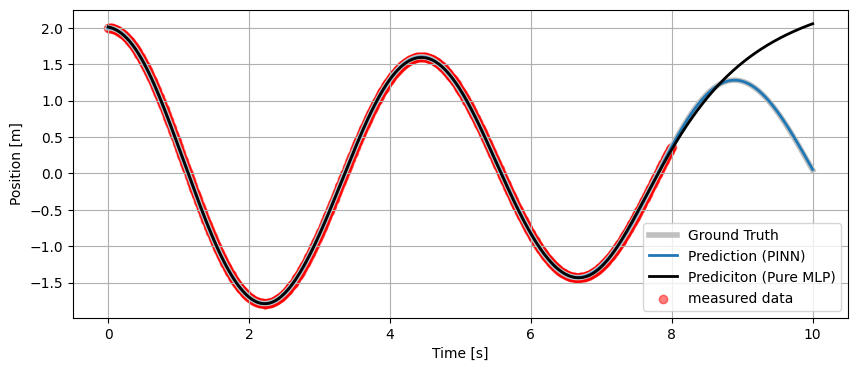

In [263]:
# Time series

ts_torch = torch.from_numpy(ts).type(torch.float32)
ts_torch = ts_torch[:,None]

plt.figure(figsize=(10, 4))
plt.plot(ts, xGood[0, :],color = "silver", lw = 4)
plt.plot(ts, model( ts_torch ).detach().numpy(),lw = 2)
plt.plot(ts, model_mlp( ts_torch ).detach().numpy(), color = "black", lw = 2)
plt.scatter(t_train, u_train,alpha=0.5, c = "red")
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.legend(['Ground Truth', 'Prediction (PINN)', "Prediciton (Pure MLP)","measured data"])
plt.grid(True)

Parameter containing:
tensor([2.0009], requires_grad=True)


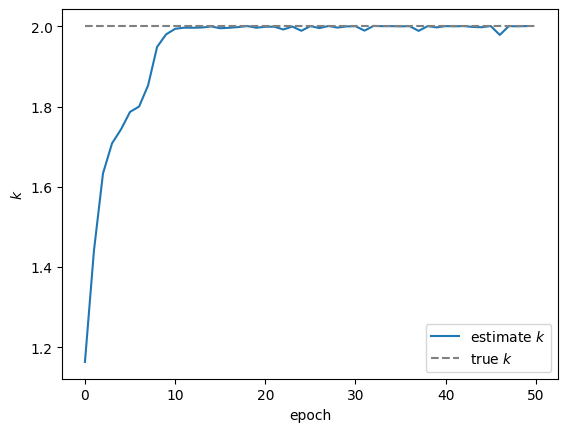

In [264]:
print(f_model.k)

plt.plot(np.asarray(Alpha), label = r"estimate $k$")
plt.plot(np.linspace(0,n_epoch, n_epoch), k*np.ones(n_epoch),"--", color = "gray", label = r"true $k$")
plt.ylabel(r"$k$")
plt.xlabel("epoch")
plt.legend()

Parameter containing:
tensor([0.1004], requires_grad=True)


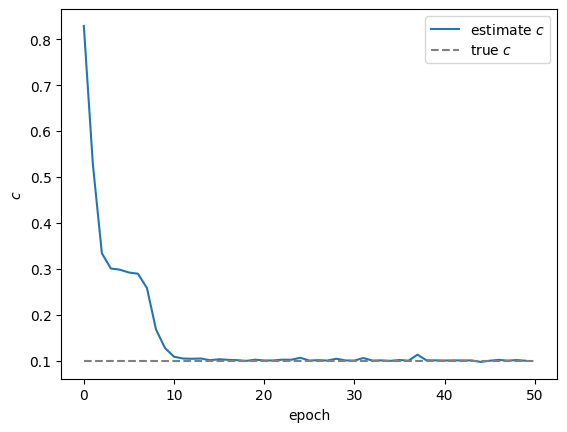

In [265]:
print(f_model.c)

plt.plot(np.asarray(Alpha_c), label = r"estimate $c$")
plt.plot(np.linspace(0,n_epoch, n_epoch), d*np.ones(n_epoch),"--", color = "gray", label = r"true $c$")
plt.ylabel(r"$c$")
plt.xlabel("epoch")
plt.legend()